In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import style
import pickle
import colorsys
import csv
import algo as map
style.use('plotting.mplstyle')

## Load in mapped paths

In [58]:
import csv

def export_to_csv(data_dict, filename, plot_indices):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Define headers dynamically: separate eta and chi_eff columns for each mapper
        headers = []
        for i in plot_indices:
            headers.extend([f"eta_{i}", f"chi_eff_{i}"])  
        writer.writerow(headers)

        # Collect eta-chi_eff pairs for each mapper
        eta_chieff_dict = {i: [] for i in plot_indices}

     # Extract and sort eta values for each mapper separately
    for i in plot_indices:
        if i in data_dict:
            points = sorted(data_dict[i]['mapper'].points, key=lambda point: eta(point[0]))  
            eta_chieff_dict[i] = [(eta(point[0]), chieff3(point[0], point[1], point[2])) for point in points]

        # Determine the max number of rows needed (some mappers may have more points than others)
        max_rows = max(len(eta_chieff_dict[i]) for i in plot_indices)

        # Write rows to the CSV
        for row_idx in range(max_rows):
            row = []
            for i in plot_indices:
                if row_idx < len(eta_chieff_dict[i]):  # Ensure index exists
                    row.extend(eta_chieff_dict[i][row_idx])  # Append eta and chi_eff
                else:
                    row.extend(["", ""])  # Empty values for missing data
            writer.writerow(row)

# Define indices to extract
plot_indices = [0, 4, 8]


export_to_csv(data_dict3D_90, "mapped_paths_3D.csv", plot_indices)

ValueError: I/O operation on closed file.

In [57]:
def chieff3(q,z1,z2):
    chieff = (q*z1+z2)/(q+1)
    return chieff
def eta(q):
    return q/(q+1)**2

In [33]:
kappa_values_2d = [4.5, 9.0, 12.8]
kappa_values_3d = [12, 13, 9]

In [34]:
df_2d = pd.read_csv("mapped_paths_2D.csv")
df_3d = pd.read_csv("mapped_paths_3D.csv")

## Generate background points

In [35]:
PS = []
map.load_and_update_model('90')
lams = [[0.16, 0.0, 0, -0.5, 0.0, 0, -0.5],[0.1875, 0, 0, 0, 0, 0, 0],[0.24, 0, 0, 0.5, 0, 0, 0.5]]
for lam0 in lams:
    ps = map.ParameterSpace(lam0 = lam0,  sample=10000, precession = False)
    PS.append(ps)

100%|██████████| 9999/9999 [00:00<00:00, 16873.23it/s]


313/313 [==============================] - 1s 1ms/step


100%|██████████| 9999/9999 [00:04<00:00, 2283.63it/s] 


313/313 [==============================] - 0s 1ms/step


100%|██████████| 9999/9999 [00:00<00:00, 17763.77it/s]


313/313 [==============================] - 0s 1ms/step


In [48]:
def fig7(name):
    fig = plt.figure(figsize=(19, 6))  
    gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1,0.04,  0.07],  wspace=0, hspace=0)
    
    axes = []
    for col in range(3):
        ax = fig.add_subplot(gs[0, col])
        axes.append(ax)

        if col > 0:
            ax.yaxis.set_visible(False)

    norm = Normalize(vmin=0, vmax=1)
    for idx, (i, ax) in enumerate(zip(plot_indices, axes)):
        
        #Add background points
        ax.scatter(PS[idx].eta, PS[idx].chi_eff, c=PS[idx].mismatch, cmap='pink',rasterized = True)

        #Add 2D points
        eta_vals = df_2d[f"eta_{i}"]
        chi_eff_vals = df_2d[f"chi_eff_{i}"]
       
        ax.plot(eta_vals, chi_eff_vals, color='lightskyblue', alpha = 0.9,linestyle='-', lw=4, zorder=100, label ='$\mathbf{x^{(\mathrm{eff})}}$')
        
        ax.plot(PS[idx].eta[0], PS[idx].chi_eff[0], '*', markersize=35, markerfacecolor='black',
                markeredgecolor='lightskyblue', markeredgewidth=1.5, zorder =150)

        # Add 3D points
        eta_vals = df_3d[f"eta_{i}"]
        chi_eff_vals = df_3d[f"chi_eff_{i}"]
        ax.plot(eta_vals, chi_eff_vals, color='lightskyblue', linestyle='--', lw=4.5,zorder=100, label ='$\mathbf{x^{(\mathrm{al})}}$')
        

        ax.set_xlim(0.122, 0.25)
        ax.set_ylim(-0.9, 0.9)
        
        if i == 8:
            ax.legend(loc ="lower right", frameon = True, fontsize = 20)
        
        # Loop through and plot kappa annotations
        for idx, ax in enumerate(axes): 
            kappa_2d = kappa_values_2d[idx]
            kappa_3d = kappa_values_3d[idx]

            # Add annotation to each panel
            ax.annotate(
               rf'$r_\mathrm{{(eff)}}={kappa_2d}$' + '\n' + rf'$r_\mathrm{{(al)}}={kappa_3d}$',
                xy=(0.1, 0.85), 
                xycoords='axes fraction', 
                fontsize=20, 
                fontweight='bold', 
                bbox=dict(boxstyle="square,pad=0.5", edgecolor="k", linestyle='--', facecolor="white")
            )

    # Set y-ticks for the first subplot
    axes[0].set_yticks([-0.5, 0, 0.5])
    axes[0].tick_params(axis='y', labelsize=28)

    # Set x-ticks for the bottom subplots
    for ax in axes:
        ax.set_xticks([0.13, 0.17, 0.21])
        ax.tick_params(axis='x', labelsize=28)
        
  

    # Add labels for axes
    fig.text(0.5, -0.01, '$\eta$', ha='center', fontsize=36)
    fig.text(-0.01, 0.5, '$\chi_{\mathrm{eff}}$', va='center', rotation='vertical', fontsize=36)

    # Add the collective colorbar to the right
    cbar_ax = fig.add_subplot(gs[:, 4])
    sm = ScalarMappable(cmap='pink',norm = norm)
    sm.set_array([])  # Empty array for colormap reference
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('$\mathcal{MM}$', size=32)
    cbar.ax.tick_params(labelsize=22)
  
    plt.tight_layout()
    plt.savefig(name + '.png', bbox_inches='tight', pad_inches=0.5)

/tmp/ipykernel_2803805/4143546559.py:74: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sm, cax=cbar_ax)


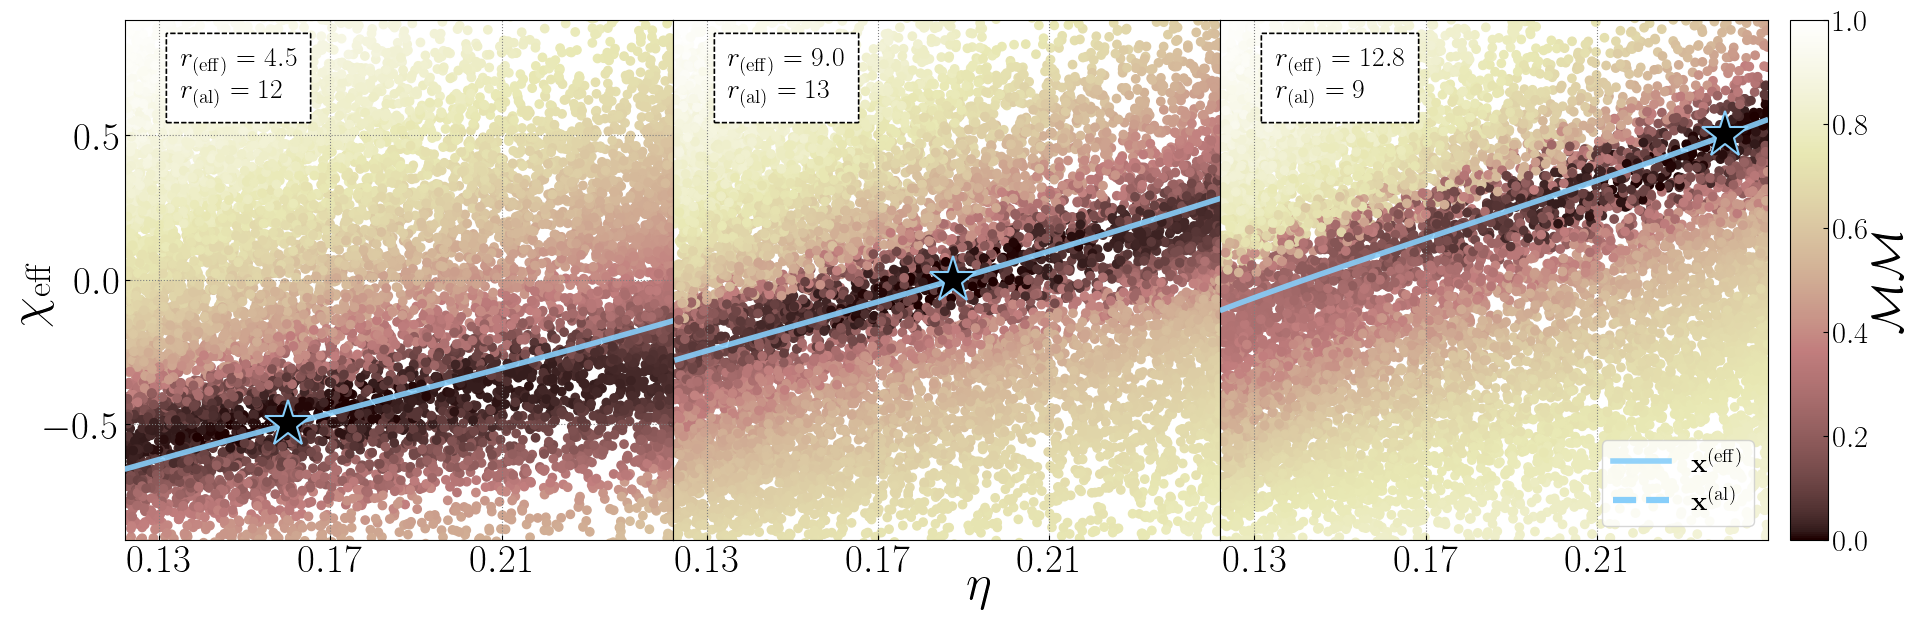

In [49]:
fig7('90_2D_3D')